In [ ]:

!pip install --upgrade tensorflow
!pip install --upgrade numpy
import os
os.kill(os.getpid(), 9)


  Using cached tensorflow-2.19.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.9.2-py3-none-any.whl.metadata (6.1 kB)
  Using cached numpy-2.1.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached tensorflow-2.19.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (644.9 MB)
Using cached keras-3.9.2-py3-none-any.whl (1.3 MB)
Using cached numpy-2.1.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.3 MB)
Using cached tensorboard-2.19.0-py3-none-any.whl (5.5 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.13.0
    Uninstalling tensorboard-2.13.0:
      Successfully uninstalled tensorboard-2.13.0
  Attempting uninstall: ke

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


In [12]:
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

BATCH_SIZE = 512

(ds_train, ds_test), ds_info = tfds.load(
    "cifar10",
    split=["train", "test"],
    as_supervised=True,
    with_info=True,
)

ds_train = ds_train.map(preprocess).shuffle(10000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [4]:
def build_softmax_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(32, 32, 3)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

softmax_model = build_softmax_model()
softmax_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

softmax_model.fit(ds_train, validation_data=ds_test, epochs=10)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


196/196 ━━━━━━━━━━━━━━━━━━━━ 68s 330ms/step - accuracy: 0.1882 - loss: 2.1499 - val_accuracy: 0.3010 - val_loss: 1.8670
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 55s 279ms/step - accuracy: 0.2968 - loss: 1.8470 - val_accuracy: 0.3390 - val_loss: 1.7288
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 58s 293ms/step - accuracy: 0.3396 - loss: 1.7282 - val_accuracy: 0.3664 - val_loss: 1.6982
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 53s 270ms/step - accuracy: 0.3673 - loss: 1.6766 - val_accuracy: 0.3829 - val_loss: 1.6313
Epoch 5/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 85s 288ms/step - accuracy: 0.3796 - loss: 1.6478 - val_accuracy: 0.3865 - val_loss: 1.6150
Epoch 6/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 80s 278ms/step - accuracy: 0.3935 - loss: 1.6116 - val_accuracy: 0.4134 - val_loss: 1.5690
Epoch 7/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 53s 268ms/step - accuracy: 0.4094 - loss: 1.5837 - val_accuracy: 0.4302 - val_loss: 1.5417
Epoch 8/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 53s 265ms/step - accuracy: 0.4281 - loss: 1.5563 - val

In [9]:
class SupervisedContrastiveLoss(tf.keras.losses.Loss):
    def __init__(self, temperature=0.1, name=None):
        super().__init__(name=name)
        self.temperature = temperature

    def call(self, labels, features):
        # Normalize feature vectors
        features = tf.math.l2_normalize(features, axis=1)
        similarity_matrix = tf.matmul(features, features, transpose_b=True) / self.temperature

        # Mask out self-comparisons
        batch_size = tf.shape(labels)[0]
        logits_mask = tf.ones_like(similarity_matrix) - tf.eye(batch_size)
        similarity_matrix = similarity_matrix * logits_mask

        # Create mask where labels[i] == labels[j]
        labels = tf.reshape(labels, [-1, 1])
        mask = tf.equal(labels, tf.transpose(labels))
        mask = tf.cast(mask, tf.float32) * logits_mask

        # LogSumExp denominator
        exp_logits = tf.exp(similarity_matrix) * logits_mask
        log_prob = similarity_matrix - tf.math.log(tf.reduce_sum(exp_logits, axis=1, keepdims=True) + 1e-8)

        # Only keep positive pairs
        mean_log_prob_pos = tf.reduce_sum(mask * log_prob, axis=1) / (tf.reduce_sum(mask, axis=1) + 1e-8)

        loss = -tf.reduce_mean(mean_log_prob_pos)
        return loss


In [10]:
def build_encoder():
    return tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, 3, activation='relu', input_shape=(32, 32, 3)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(128, 3, activation='relu'),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu')
    ])

def build_projection_head():
    return tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64)
    ])

encoder = build_encoder()
projector = build_projection_head()
contrastive_loss = SupervisedContrastiveLoss()
optimizer = tf.keras.optimizers.Adam()


In [13]:
@tf.function
def train_step_contrastive(x, y):
    with tf.GradientTape() as tape:
        features = encoder(x)
        projections = projector(features)
        loss = contrastive_loss(y, projections)
    grads = tape.gradient(loss, encoder.trainable_variables + projector.trainable_variables)
    optimizer.apply_gradients(zip(grads, encoder.trainable_variables + projector.trainable_variables))
    return loss

# Train
for epoch in range(10):
    total_loss = 0
    batches = 0
    for x_batch, y_batch in ds_train:
        loss = train_step_contrastive(x_batch, y_batch)
        total_loss += loss
        batches += 1
    print(f"Epoch {epoch+1}, Contrastive Loss: {total_loss / batches:.4f}")


Epoch 1, Contrastive Loss: 5.9593
Epoch 2, Contrastive Loss: 5.8414
Epoch 3, Contrastive Loss: 5.7558
Epoch 4, Contrastive Loss: 5.6964
Epoch 5, Contrastive Loss: 5.6471
Epoch 6, Contrastive Loss: 5.6123
Epoch 7, Contrastive Loss: 5.5804
Epoch 8, Contrastive Loss: 5.5469
Epoch 9, Contrastive Loss: 5.5198
Epoch 10, Contrastive Loss: 5.4818


In [14]:
encoder.trainable = False
linear_model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
linear_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
linear_model.fit(ds_train, validation_data=ds_test, epochs=10)


Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 52s 509ms/step - accuracy: 0.2309 - loss: 2.2824 - val_accuracy: 0.4441 - val_loss: 2.1666
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 59s 603ms/step - accuracy: 0.4555 - loss: 2.0930 - val_accuracy: 0.4786 - val_loss: 1.8616
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 50s 508ms/step - accuracy: 0.4939 - loss: 1.7988 - val_accuracy: 0.4908 - val_loss: 1.6410
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 80s 486ms/step - accuracy: 0.5043 - loss: 1.5990 - val_accuracy: 0.5109 - val_loss: 1.4929
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 50s 509ms/step - accuracy: 0.5266 - loss: 1.4560 - val_accuracy: 0.5296 - val_loss: 1.3843
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 50s 506ms/step - accuracy: 0.5480 - loss: 1.3565 - val_accuracy: 0.5461 - val_loss: 1.3075
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 80s 481ms/step - accuracy: 0.5586 - loss: 1.2832 - val_accuracy: 0.5520 - val_loss: 1.2525
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 84s 507ms/step - accuracy: 0.5699 - loss: 1.2284 - val_accu

In [18]:
# Rebuild the softmax model from scratch to extract embeddings
def get_softmax_encoder_model():
    inputs = tf.keras.Input(shape=(32, 32, 3))
    x = tf.keras.layers.Conv2D(32, 3, activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64, 3, activation='relu')(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)  # <-- Extract from here
    outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model, tf.keras.Model(inputs, x)  # return full model and encoder

# Recreate and load trained weights from your original softmax model
full_softmax_model, baseline_encoder = get_softmax_encoder_model()
full_softmax_model.set_weights(softmax_model.get_weights())  # Copy trained weights


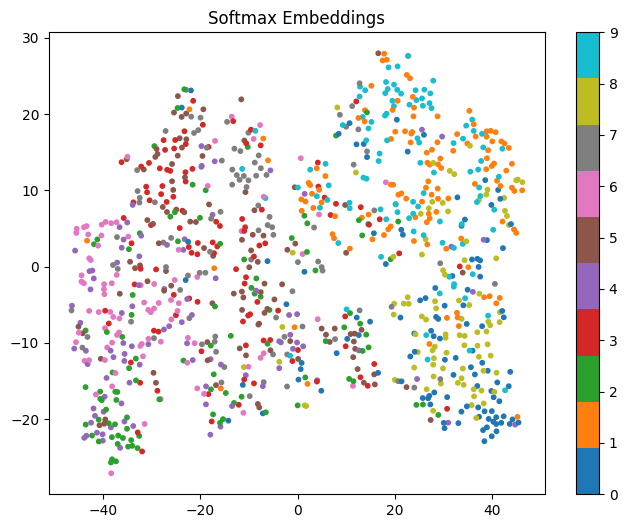

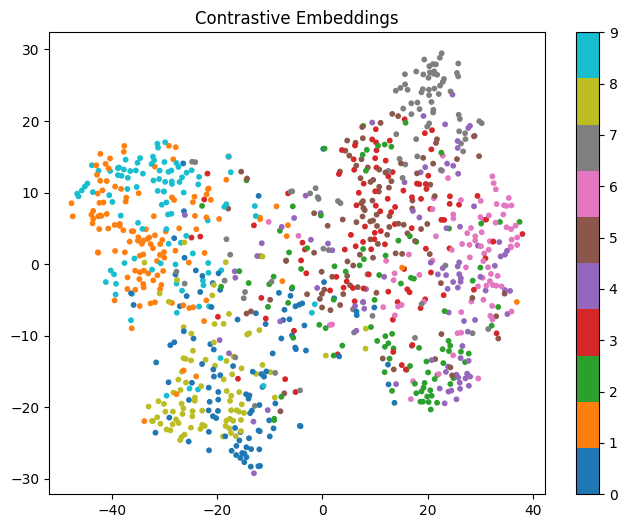

In [19]:
emb1, y1 = extract_embeddings(baseline_encoder, ds_test)
plot_tsne(emb1, y1, "Softmax Embeddings")

emb2, y2 = extract_embeddings(encoder, ds_test)
plot_tsne(emb2, y2, "Contrastive Embeddings")
